Input Columns for dataset1: ['height_over_sea_level', 'fall', 'net', 'flow']
Output Column for dataset1: fall_1
Input Columns for dataset2: ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']
Output Column for dataset2: z
Input Columns for dataset3: ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
Output Column for dataset3: Y house price of unit area
MAPE for Dataset Turbine: 3.14%
MAPE for Dataset synthetic : 10.92%
MAPE for Dataset realestate: 19.48%


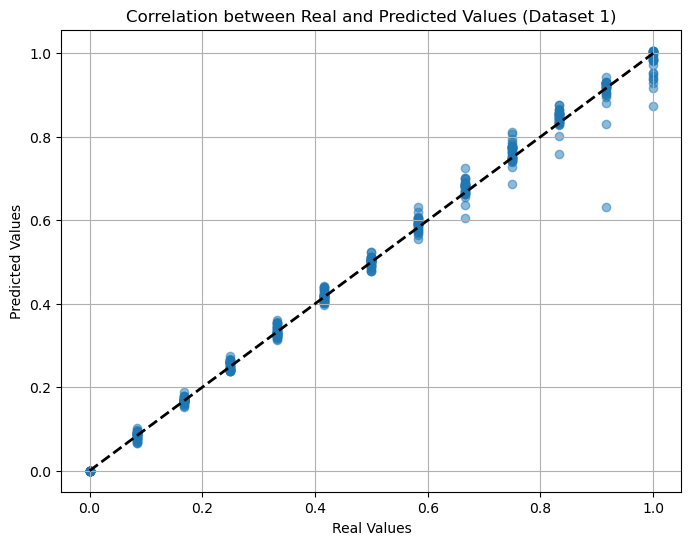

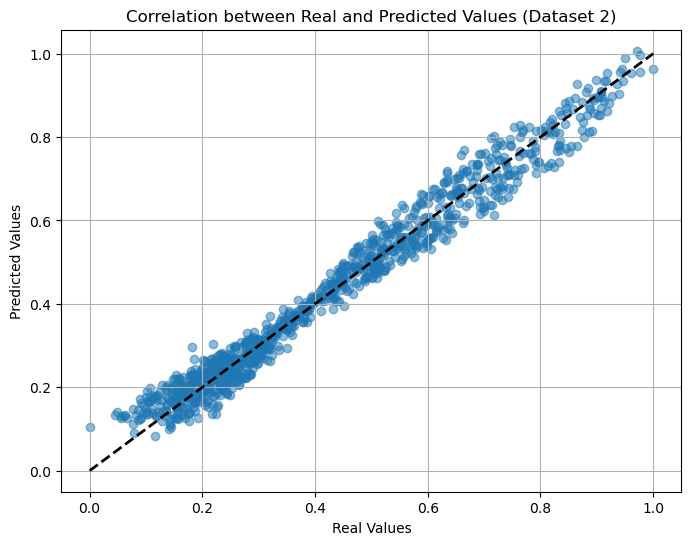

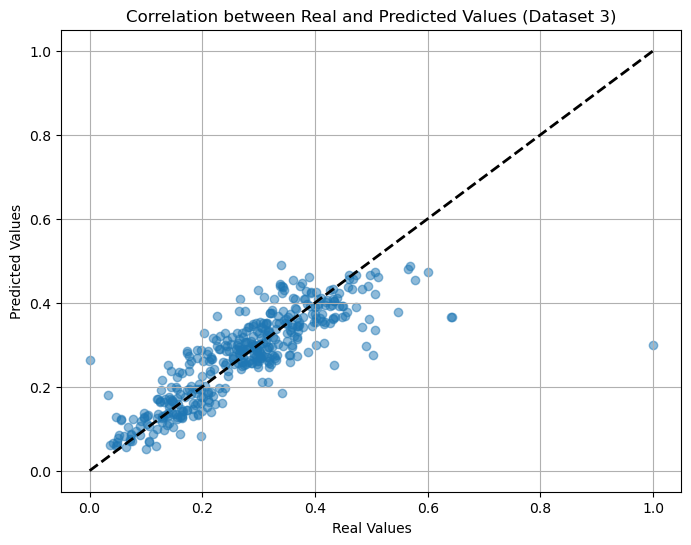

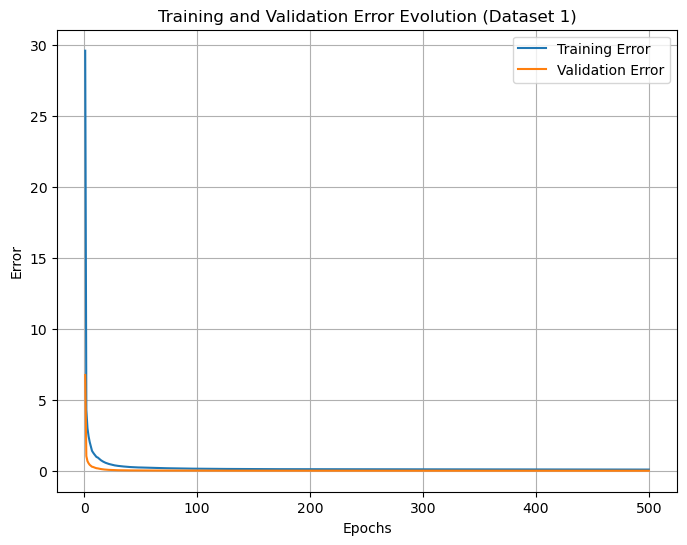

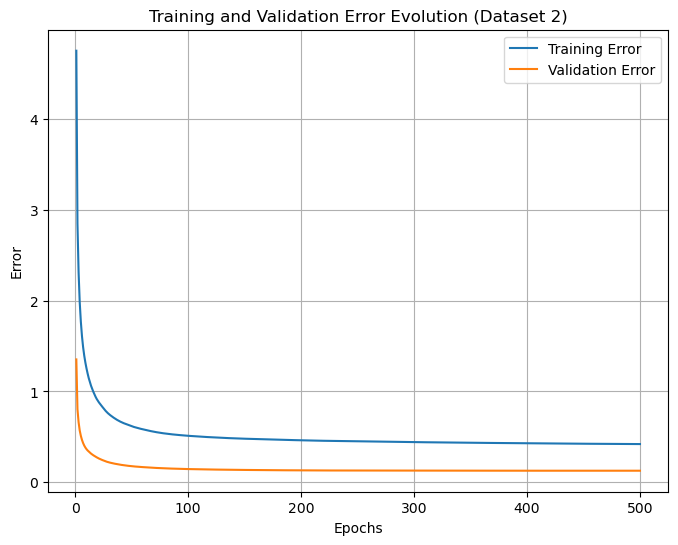

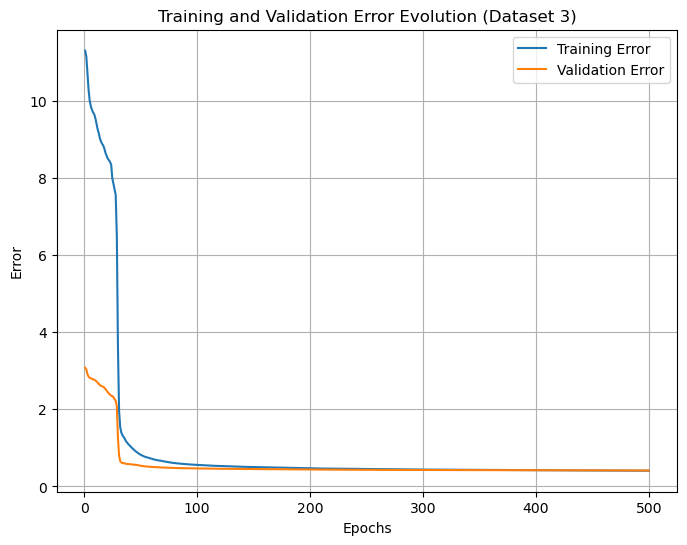

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# Code for MyNeuralNetwork class
class MyNeuralNetwork:
    def __init__(self, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage):
        self.L = num_layers
        self.n = num_units
        self.num_epochs = num_epochs
        self.eta = learning_rate
        self.alpha = momentum
        self.fact = activation_function
        self.validation_percentage = validation_percentage
        self.xi = [np.zeros(layer_units) for layer_units in num_units]
        self.h = [np.zeros(layer_units) for layer_units in num_units]
        self.w = [None] + [np.random.randn(num_units[i], num_units[i - 1]) * np.sqrt(2 / num_units[i - 1]) for i in range(1, num_layers)]
        self.theta = [np.zeros(layer_units) for layer_units in num_units]
        self.delta = [np.zeros(layer_units) for layer_units in num_units]
        self.d_w = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.d_theta = [np.zeros(layer_units) for layer_units in num_units]
        self.d_w_prev = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.d_theta_prev = [np.zeros(layer_units) for layer_units in num_units]
        self.training_error = []
        self.validation_error = []

    # Sigmoid activation function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def linear(self, x):
        return x

    def linear_derivative(self, x):
        return np.ones_like(x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - x**2

    def activation(self, x):
        if self.fact == 'sigmoid':
            return self.sigmoid(x)
        elif self.fact == 'relu':
            return self.relu(x)
        elif self.fact == 'linear':
            return self.linear(x)
        elif self.fact == 'tanh':
            return self.tanh(x)

    def activation_derivative(self, x):
        if self.fact == 'sigmoid':
            return self.sigmoid_derivative(x)
        elif self.fact == 'relu':
            return self.relu_derivative(x)
        elif self.fact == 'linear':
            return self.linear_derivative(x)
        elif self.fact == 'tanh':
            return self.tanh_derivative(x)

    def feed_forward(self, sample):
        self.xi[0] = sample
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l - 1]) - self.theta[l]
            self.xi[l] = self.activation(self.h[l])

    def backpropagate(self, target):
        self.delta[self.L - 1] = self.activation_derivative(self.xi[self.L - 1]) * (self.xi[self.L - 1] - target)
        for l in range(self.L - 2, 0, -1):
            self.delta[l] = self.activation_derivative(self.xi[l]) * np.dot(self.w[l + 1].T, self.delta[l + 1])

    def update_weights(self):
        for l in range(1, self.L):
            self.d_w[l] = -self.eta * np.outer(self.delta[l], self.xi[l - 1]) + self.alpha * self.d_w_prev[l]
            self.d_theta[l] = self.eta * self.delta[l] + self.alpha * self.d_theta_prev[l]
            self.w[l] += self.d_w[l]
            self.theta[l] += self.d_theta[l]
            self.d_w_prev[l] = self.d_w[l]
            self.d_theta_prev[l] = self.d_theta[l]

    def calculate_total_error(self, X, y):
        total_error = 0.0
        for i in range(X.shape[0]):
            self.feed_forward(X[i])
            total_error += 0.5 * np.sum((self.xi[self.L - 1] - y[i]) ** 2)
        return total_error

    def fit(self, X, y):
        # Splitting data into training and validation sets
        n_samples = X.shape[0]
        if self.validation_percentage > 0:
            n_train = int(n_samples * (1.0 - self.validation_percentage))
            X_train = X[:n_train]
            y_train = y[:n_train]
            X_val = X[n_train:]
            y_val = y[n_train:]
        else:
            X_train = X
            y_train = y
            X_val = np.array([])
            y_val = np.array([])

        for epoch in range(self.num_epochs):
            for i in range(X_train.shape[0]):
                sample = X_train[i]
                target = y_train[i]

                self.feed_forward(sample)
                self.backpropagate(target)
                self.update_weights()

            # Calculate training error
            train_error = self.calculate_total_error(X_train, y_train)
            self.training_error.append(train_error)

            # Calculate validation error
            if X_val.shape[0] > 0:
                val_error = self.calculate_total_error(X_val, y_val)
                self.validation_error.append(val_error)

    def predict(self, X):
        predictions = []
        for sample in X:
            self.feed_forward(sample)
            predictions.append(self.xi[self.L - 1].copy())
        return np.array(predictions)

    # Function to retrieve epoch-wise loss data
    def get_epoch_losses(self):
        epochs = list(range(1, self.num_epochs + 1))
        return np.column_stack((epochs, self.training_error, self.validation_error))

    # Modify the loss_epochs() function to use get_epoch_losses()
    def loss_epochs(self):
        return self.get_epoch_losses()

# Function to train neural network on a given dataset
def train_neural_network(dataset, input_columns, output_column, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage):
    X = dataset[input_columns].values
    y = dataset[output_column].values.reshape(-1, 1)

    nn = MyNeuralNetwork(num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage)
    
    nn.fit(X, y)
    
    X_test = X  
    predictions = nn.predict(X_test)

    return nn, predictions

# Function to normalize the input features
def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# Function to train neural network on a given dataset
def train_neural_network(dataset, input_columns, output_column, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage):
    X = dataset[input_columns].values
    y = dataset[output_column].values.reshape(-1, 1)

    # Remove rows with missing target values (NaN)
    dataset = clean_dataset(dataset, output_column)

    # Normalize features
    X = normalize_features(X)

    nn = MyNeuralNetwork(num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage)
    
    # Splitting data into training and validation sets after removing missing values
    n_samples = X.shape[0]
    if validation_percentage > 0:
        n_train = int(n_samples * (1.0 - validation_percentage))
        X_train = X[:n_train]
        y_train = y[:n_train]
    else:
        X_train = X
        y_train = y
     

    nn.fit(X_train, y_train)

    # Predict on the normalized features
    predictions = nn.predict(X)
    return nn, predictions

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred, epsilon=1e-8):
    # Ensure both y_true and y_pred are numpy arrays for consistency
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Avoid division by zero and return NaN if all y_true values are close to zero
    if np.all(np.abs(y_true) < epsilon):
        return np.nan
    
    # Apply a mask to avoid division by zero
    mask = y_true != 0
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100
    return mape


# Function to clean dataset by removing rows with NaN in the target column
def clean_dataset(dataset, target_column):
    return dataset.dropna(subset=[target_column])

# Loading the datasets
dataset1 = pd.read_csv('normalized_dataset1.csv', delimiter=',')


# Drop the column if it exists
if 'power_of_hydroelectrical_turbine' in dataset1.columns:
    dataset1 = dataset1.drop(columns=['power_of_hydroelectrical_turbine'])

dataset2 = pd.read_csv('normalized_dataset2.csv')    
dataset3 = pd.read_csv('normalized_dataset3.csv')

# Defining input and output columns for dataset 2
# Updated input columns for dataset2
input_columns1 = ['height_over_sea_level', 'fall', 'net' , 'flow']
output_column1 = 'fall_1'  # This is the correct output column

print("Input Columns for dataset1:", input_columns1)
print("Output Column for dataset1:", output_column1)

# Defining input and output columns for each dataset
input_columns2 = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']
output_column2 = 'z'


print("Input Columns for dataset2:", input_columns2)
print("Output Column for dataset2:", output_column2)

# Defining input and output columns for dataset 3
input_columns3 = ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']
output_column3 = 'Y house price of unit area'

print("Input Columns for dataset3:", input_columns3)
print("Output Column for dataset3:", output_column3)

# Neural network configurations for each dataset
num_layers = 4
num_units1 = [len(input_columns1)] + [10, 5, 1]
num_units2 = [len(input_columns2)] + [10, 5, 1]
num_units3 = [len(input_columns3)] + [8, 4, 1]
num_epochs = 500
learning_rate = 0.002
momentum = 0.9
activation_function = "relu"

# Training the neural network for dataset 1
nn1, predictions1 = train_neural_network(dataset1, input_columns1, output_column1, num_layers, num_units1, num_epochs, learning_rate, momentum, activation_function, 0.15)

# Training the neural network for dataset 2 (after removing the last column)
nn2, predictions2 = train_neural_network(dataset2, input_columns2, output_column2, num_layers, num_units2, num_epochs, learning_rate, momentum, activation_function, 0.20)

# Training the neural network for dataset 3
nn3, predictions3 = train_neural_network(dataset3, input_columns3, output_column3, num_layers, num_units3, num_epochs, learning_rate, momentum, activation_function, 0.20)

# Predicted values and dataset1 contains the real values for dataset 1
real_values_1 = dataset1[output_column1].values.reshape(-1, 1)
mape1 = calculate_mape(real_values_1, predictions1)

# Formatting the MAPE as a percentage
if not np.isnan(mape1):
    print(f"MAPE for Dataset Turbine: {mape1:.2f}%")
else:
    print("MAPE for Dataset Turbine : Undefined")

# Predicted values and dataset2 contains the real values for dataset 2
# Calculate MAPE for Dataset 2 after removing missing values
real_values2 = dataset2[output_column2].values.reshape(-1, 1)
predictions2 = np.array(predictions2)
mape2 = calculate_mape(real_values2, predictions2)
print(f"MAPE for Dataset synthetic : {mape2:.2f}%")

# Predicted values and dataset3 contains the real values for dataset 3
real_values_3 = dataset3[output_column3].values.reshape(-1, 1)
mape3 = calculate_mape(real_values_3, predictions3)

# Formatting the MAPE as a percentage
if not np.isnan(mape3):
    print(f"MAPE for Dataset realestate: {mape3:.2f}%")
else:
    print("MAPE for Dataset realestate: Undefined")



# The scatter plot for dataset 1
plt.figure(figsize=(8, 6))
plt.scatter(real_values_1, predictions1, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Correlation between Real and Predicted Values (Dataset 1)')
plt.grid(True)
plt.plot([real_values_1.min(), real_values_1.max()], [real_values_1.min(), real_values_1.max()], 'k--', lw=2) # diagonal line
plt.savefig('correlation_plot_dataset1.png')
plt.show()

# The scatter plot for dataset 2
plt.figure(figsize=(8, 6))
plt.scatter(real_values2, predictions2, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Correlation between Real and Predicted Values (Dataset 2)')
plt.grid(True)
plt.plot([real_values2.min(), real_values2.max()], [real_values2.min(), real_values2.max()], 'k--', lw=2) # diagonal line
plt.savefig('correlation_plot_dataset2.png')
plt.show()

# The scatter plot for dataset 3
plt.figure(figsize=(8, 6))
plt.scatter(real_values_3, predictions3, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Correlation between Real and Predicted Values (Dataset 3)')
plt.grid(True)
plt.plot([real_values_3.min(), real_values_3.max()], [real_values_3.min(), real_values_3.max()], 'k--', lw=2) # diagonal line
plt.savefig('correlation_plot_dataset3.png')
plt.show()

# Saving predictions to files
np.savetxt("predictions_dataset1.csv", predictions1, delimiter=",")
np.savetxt("predictions_dataset2.csv", predictions2, delimiter=",")
np.savetxt("predictions_dataset3.csv", predictions3, delimiter="")

# Plotting training and validation error evolution for each dataset
loss_data1 = nn1.loss_epochs()
loss_data2 = nn2.loss_epochs()
loss_data3 = nn3.loss_epochs()

# Training and validation error evolution for Dataset 1
plt.figure(figsize=(8, 6))
plt.plot(loss_data1[:, 0], loss_data1[:, 1], label='Training Error')
plt.plot(loss_data1[:, 0], loss_data1[:, 2], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error Evolution (Dataset 1)')
plt.legend()
plt.grid(True)
plt.savefig('error_evolution_dataset1.png')
plt.show()

# Training and validation error evolution for Dataset 2
plt.figure(figsize=(8, 6))
plt.plot(loss_data2[:, 0], loss_data2[:, 1], label='Training Error')
plt.plot(loss_data2[:, 0], loss_data2[:, 2], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error Evolution (Dataset 2)')
plt.legend()
plt.grid(True)
plt.savefig('error_evolution_dataset2.png')
plt.show()

# Training and validation error evolution for Dataset 3
plt.figure(figsize=(8, 6))
plt.plot(loss_data3[:, 0], loss_data3[:, 1], label='Training Error')
plt.plot(loss_data3[:, 0], loss_data3[:, 2], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error Evolution (Dataset 3)')
plt.legend()
plt.grid(True)
plt.savefig('error_evolution_dataset3.png')
plt.show()

# Saving loss data to files
loss_data1 = nn1.loss_epochs()
loss_data2 = nn2.loss_epochs()
loss_data3 = nn3.loss_epochs()
np.savetxt("loss_data_dataset1.csv", loss_data1, delimiter=",")
np.savetxt("loss_data_dataset2.csv", loss_data2, delimiter=",")
np.savetxt("loss_data_dataset3.csv", loss_data3, delimiter=",")